<a href="https://colab.research.google.com/github/xuxiufeng/Connect_X/blob/main/Connect_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

In [ ]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from random import choice
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make

In [ ]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)


In [ ]:
class QTable:
    def __init__(self, action_space):
        self.table = dict()
        self.action_space = action_space
        
    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.action_space.n))
        
    def __call__(self, state):
        board = state.board[:] # Get a copy
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        state_key = hex(int(''.join(state_key), 3))[2:]
        if state_key not in self.table.keys():
            self.add_item(state_key)
        
        return self.table[state_key]



In [ ]:
env = ConnectX()

In [ ]:
alpha = 0.1
gamma = 0.6
epsilon = 0.99
min_epsilon = 0.1

episodes = 10000

alpha_decay_step = 1000
alpha_decay_rate = 0.9
epsilon_decay_rate = 0.9999

In [ ]:
q_table = QTable(env.action_space)

all_epochs = []
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_qtable_rows = []
all_epsilons = []

for i in tqdm(range(episodes)):
    state = env.reset()

    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
    epochs, total_rewards = 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = choice([c for c in range(env.action_space.n) if state.board[c] == 0])
        else:
            row = q_table(state)[:]
            selected_items = []
            for j in range(env.action_space.n):
                if state.board[j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(-1e7)
            action = int(np.argmax(selected_items))

        next_state, reward, done, info = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        old_value = q_table(state)[action]
        next_max = np.max(q_table(next_state))
        
        # Update Q-value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table(state)[action] = new_value

        state = next_state
        epochs += 1
        total_rewards += reward


    all_epochs.append(epochs)
    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)
    all_qtable_rows.append(len(q_table.table))
    all_epsilons.append(epsilon)
  
    if (i+1) % alpha_decay_step == 0:
        alpha *= alpha_decay_rate

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
len(q_table.table)

40620

In [ ]:
for k in q_table.table.keys():
    print('State:', k)
    print('Action-Value:', list(q_table.table[k]), '\n')

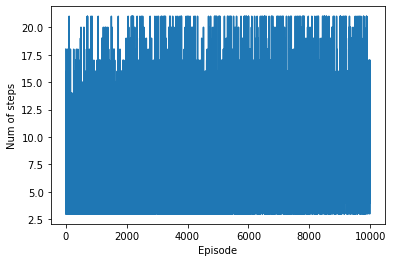

In [ ]:
plt.plot(all_epochs)
plt.xlabel('Episode')
plt.ylabel('Num of steps')
plt.show()

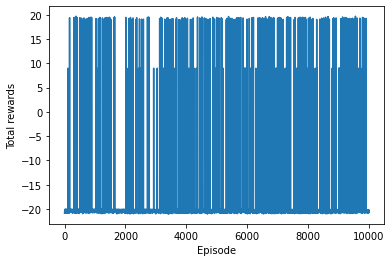

In [ ]:
plt.plot(all_total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total rewards')
plt.show()

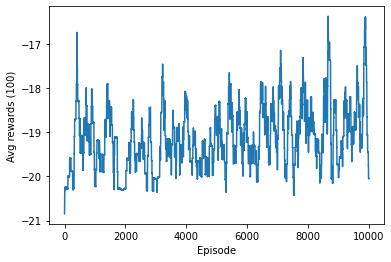

In [ ]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

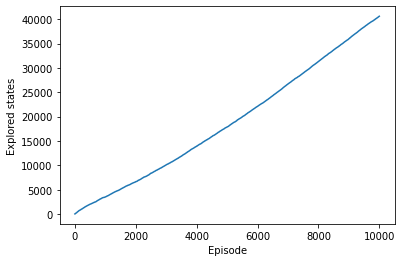

In [ ]:
plt.plot(all_qtable_rows)
plt.xlabel('Episode')
plt.ylabel('Explored states')
plt.show()

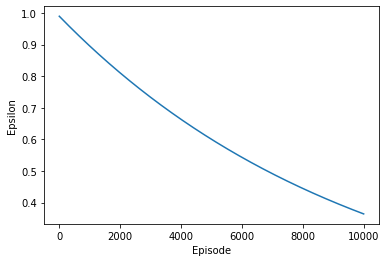

In [ ]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [ ]:
tmp_dict_q_table = q_table.table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))

In [ ]:
my_agent = '''def my_agent(observation, configuration):
    from random import choice

    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''

    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    return action
    '''

In [ ]:
with open('submission.py', 'w') as f:
    f.write(my_agent)

In [ ]:
from submission import my_agent

In [ ]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))